# Working With a SQL Database

In [145]:
# IMPORTS
import pandas as pd
import sqlalchemy as sal
from config import user, password, host, port
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

In [2]:
connection_string = f"{user}:{password}@{host}:{port}/Liquor_Sales"
engine = sal.create_engine(f'postgresql://{connection_string}')
conn = engine.connect()

In [3]:
top_df = pd.read_sql('select * from main_table limit 5;', conn)

In [4]:
top_df.head(1)

,invoice_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,S29198800001,2015-11-20,2191,Keokuk Spirits,1013 MAIN,KEOKUK,52632,"1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)",56,Lee,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,6,$162.84,4.5,1.19


In [10]:
top_df.columns

Index(['invoice_number', 'date', 'store_number', 'store_name', 'address',
       'city', 'zip_code', 'store_location', 'county_number', 'county',
       'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons'],
      dtype='object')

In [ ]:
distinct_cities = pd.read_sql('select city, count(invoice_number) from main_table group by city;', conn)

In [ ]:
distinct_cities.sort_values('count', ascending=False).head(25)

In [ ]:
stores_in_dm = pd.read_sql("select store_number, store_name, count(item_number) from main_table where city like 'DES MOINES' group by store_number, store_name;", conn)

In [ ]:
stores_in_dm.sort_values('count', ascending=False).head(10)

In [5]:
dates = pd.read_sql("select date from main_table group by date order by date desc;", conn)

In [9]:
print(dates.date[0], dates.date[len(dates.date)-1])

2017-10-31 2012-01-03


In [23]:
variable = dates.date[0]
variable
print(f"{type(variable)}")

<class 'datetime.date'>


In [30]:
last_day = dates.date[0]
sales = pd.read_sql("select date, sum(cast(sale_dollars as money)) from main_table group by date order by date desc;", conn)
sales

,date,sum
0,2017-10-31,"$757,500.03"
1,2017-10-30,"$772,762.07"
2,2017-10-27,"$382,548.46"
3,2017-10-26,"$619,829.19"
4,2017-10-25,"$817,885.95"
...,...,...
1374,2012-01-10,"$900,077.61"
1375,2012-01-09,"$933,835.50"
1376,2012-01-05,"$940,194.93"
1377,2012-01-04,"$860,053.73"


date       1379
dollars    1379
dtype: int64

In [38]:
sales.date = pd.to_datetime(sales.date).dt.strftime('%m/%d')

In [60]:
sales = sales.rename(columns={'sum': 'dollars'})

In [72]:
# https://stackoverflow.com/questions/32464280/converting-currency-with-to-numbers-in-python-pandas
sales.dollars = sales.dollars.replace('[\$,]', '', regex=True).astype(float)

In [73]:
sales.dtypes

date        object
dollars    float64
dtype: object

In [74]:
sales

,date,dollars
0,10/31,757500.03
1,10/30,772762.07
2,10/27,382548.46
3,10/26,619829.19
4,10/25,817885.95
...,...,...
1374,01/10,900077.61
1375,01/09,933835.50
1376,01/05,940194.93
1377,01/04,860053.73


In [75]:
yearly = sales.groupby(sales.date)

In [118]:
yearly_avg = yearly.mean()

In [119]:
yearly_avg = yearly_avg.reset_index(level=0)

I believe that sales will be up in the summer and down in the winter. I will measure from the equinox and solctice.

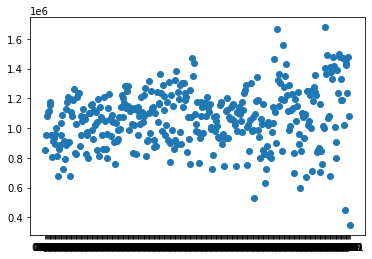

In [86]:
# plotting over course of calendar year
plt.scatter(yearly_avg.date, yearly_avg.dollars)
plt.show()

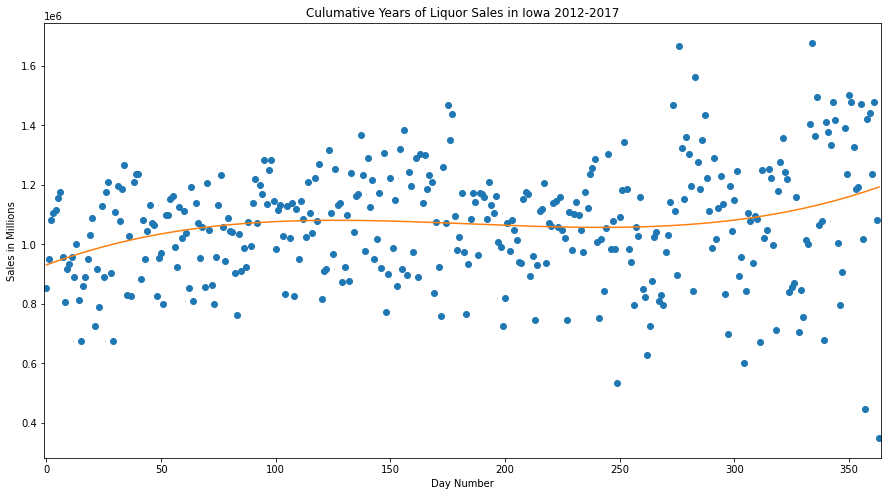

In [100]:
# https://stackoverflow.com/questions/19165259/python-numpy-scipy-curve-fitting

x = np.arange(len(yearly_avg.date.to_numpy()))
y = yearly_avg.dollars.to_numpy()

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(x[0], x[-1], len(x))
y_new = f(x_new)

plt.figure(figsize = (15, 8))
plt.plot(x,y,'o', x_new, y_new)
plt.xlim([x[0]-1, x[-1] + 1 ])

plt.title("Culumative Years of Liquor Sales in Iowa 2012-2017")
plt.xlabel("Day Number")
plt.ylabel("Sales in Millions")

plt.savefig("CYoLSiI.png", facecolor='white', transparent=False)

plt.show()

In [135]:
seasons = yearly_avg.copy()

In [136]:
# ignore year its just a place holder
seasons.date = pd.to_datetime(seasons.date, format='%m/%d', errors='coerce')

In [137]:
def quarters(dt):
    if dt > datetime.datetime(1900, 3, 21) and dt < datetime.datetime(1900, 6, 21):
        return 'spring'
    elif dt > datetime.datetime(1900, 6, 21) and dt < datetime.datetime(1900, 9, 21):
        return 'summer'
    elif dt > datetime.datetime(1900, 9, 21) and dt < datetime.datetime(1900, 12, 21):
        return 'autumn'
    else:
        return 'winter'
    

seasons['season'] = seasons.date.map(lambda x: quarters(x))

In [141]:
seasons = seasons.drop(columns=['date'])
seasons

,dollars,season
0,8.540227e+05,winter
1,9.507089e+05,winter
2,1.082011e+06,winter
3,1.105334e+06,winter
4,1.115890e+06,winter
...,...,...
359,1.439825e+06,winter
360,1.236322e+06,winter
361,1.476587e+06,winter
362,1.080521e+06,winter


In [142]:
seasons.groupby('season').mean()

,dollars
season,
autumn,1.118172e+06
spring,1.086341e+06
summer,1.049346e+06
winter,1.015103e+06


<AxesSubplot:title={'center':'dollars'}, xlabel='[season]'>

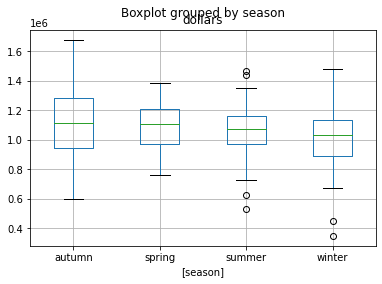

In [144]:
seasons.boxplot(by='season')

In [148]:
'''My hypothoses is that summer has more sales than winter
the null hypothesis is that summer does not have greater sales than winter with an alpha of 5%'''
summer = seasons[seasons.season == 'summer']
winter = seasons[seasons.season == 'winter']

ttest_ind(summer.dollars, winter.dollars)

Ttest_indResult(statistic=1.2912102743763063, pvalue=0.19827738334612466)

with a t score of 1.29 and a pvalue of 0.198, i cannot reject the null hypothesis. I cannot say for sure if Summer has higher sales than Winter.

In [149]:
'''I am going to test to see if there is any difference between any of the means
the null hypothesis is that there is non alpha 5%'''
summer = seasons[seasons.season == 'summer'].dollars
winter = seasons[seasons.season == 'winter'].dollars
autumn = seasons[seasons.season == 'autumn'].dollars
spring = seasons[seasons.season == 'spring'].dollars

from scipy.stats import f_oneway

f_oneway(autumn, spring, summer, winter)

F_onewayResult(statistic=5.001971534339163, pvalue=0.002070386617408077)

the pvalue is .2% < 5% so i can reject the null. There is a difference in Mean. Meaning There is some seasons that are more Profitable.

In [155]:
'''I am going to write a for loop of tests
the nulls are the following
autumn is not greater than summer/spring/winter
spring is not greater than summer/winter
summer is not greater than winter (we know how that goes)
alpha 5%'''

adict = {'a':autumn, 'm':spring, 's':summer, 'w':winter}

sometuples = {}
for x in adict:
    for y in adict:
        if x != y:
            sometuples[x+y] = (adict[x], adict[y])
            


In [159]:
answers = {}
for k in sometuples:
    season1 = sometuples[k][0]
    season2 = sometuples[k][1]
    
    t, p = ttest_ind(season1, season2)
    answers[k] = (t, p)

In [160]:
answers

{'am': (1.0623312146245119, 0.2895164793781658),
 'as': (2.233100246456167, 0.02678138074355021),
 'aw': (3.1854244026864222, 0.0017038798412991616),
 'ma': (-1.0623312146245119, 0.2895164793781658),
 'ms': (1.5744277196116727, 0.11714458874054884),
 'mw': (2.7892366890489946, 0.005848674431854004),
 'sa': (-2.233100246456167, 0.02678138074355021),
 'sm': (-1.5744277196116727, 0.11714458874054884),
 'sw': (1.2912102743763063, 0.19827738334612466),
 'wa': (-3.1854244026864222, 0.0017038798412991616),
 'wm': (-2.7892366890489946, 0.005848674431854004),
 'ws': (-1.2912102743763063, 0.19827738334612466)}

to save time i am going to make a dataframe that will chart which seasons are greater than others

In [168]:
compare = pd.DataFrame({'Autumn':['','=','+','+'], 'Spring':['=','','=','+'], 'Summer':['-','=','','='], 'Winter':['-','-','=','']})

In [169]:
compare.index = ['Autumn', 'Spring', 'Summer', 'Winter']

In [170]:
compare

,Autumn,Spring,Summer,Winter
Autumn,,=,-,-
Spring,=,,=,-
Summer,+,=,,=
Winter,+,+,=,
